# Spotify Hit Songs

## Imports
Collection of all imports used in the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

## Data Preprocessing
The .csv file is saved to a dataframe, then potential null values and duplicates are printed.

In [2]:
with open(r"./data/spotify_hit_songs.csv", 'r', encoding="utf8") as f:
    df_original = pd.read_csv(f)

In [3]:
# Print information about null values in each column
print("Null values per column:")
print(df_original.isnull().sum())

# Print information about duplicates
subset_columns = ['track', 'artist', 'uri']
print("\nCount of duplicates based on track, artist and uri:")
print(df_original[df_original.duplicated(subset=subset_columns)].shape[0])

Null values per column:
track               0
artist              0
uri                 0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
dtype: int64

Count of duplicates based on track, artist and uri:
422


### Removing Duplicates
Since duplicates were found in the dataset, the duplicates are removed and a new dataframe is created.

In [4]:
# Remove duplicates based on the specified columns
df = df_original.drop_duplicates(subset=subset_columns, keep='first')

print("Number of rows before removing duplicates:", len(df_original))
print("Number of rows after removing duplicates:", len(df))

# Print information of duplicates again to confirm removal
print("\nCount of duplicates based on track, artist and uri:")
print(df[df.duplicated(subset=subset_columns)].shape[0])

Number of rows before removing duplicates: 41106
Number of rows after removing duplicates: 40684

Count of duplicates based on track, artist and uri:
0


## Understanding the Data
Prints the occurences of hits and flops in the concatenated dataset.

In [5]:
hits_count = df['target'].value_counts().get(1, 0)
flops_count = df['target'].value_counts().get(0, 0)

print(f"Hits: {hits_count}")
print(f"Flops: {flops_count}")

Hits: 20131
Flops: 20553


Creates two plots of the mean values of the selected attributes for all hits and flops respectively in the concatenated dataset.

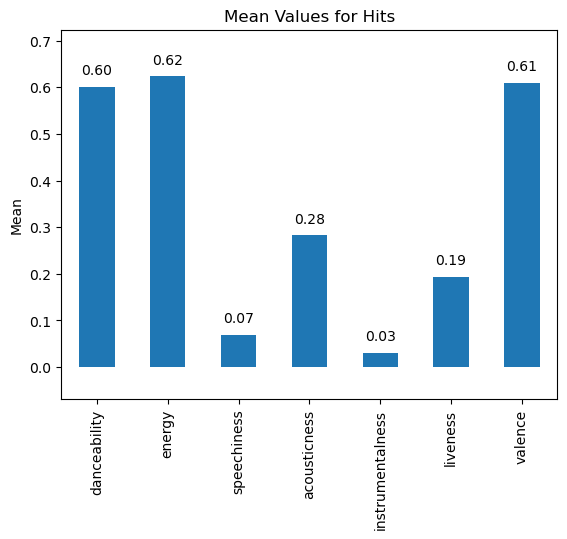

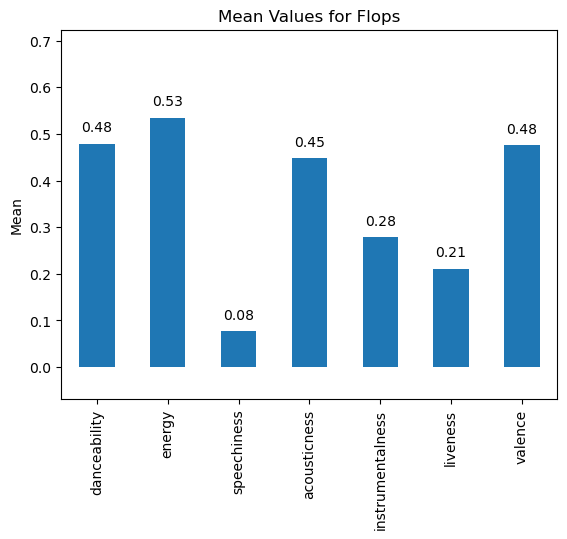

In [6]:
selected_columns = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']

# Filter DataFrame for hits and flops
hits_df = df[df['target'] == 1]
flops_df = df[df['target'] == 0]

# Plot hits
hits_means = hits_df[selected_columns].mean()
hits_means.plot(kind='bar')
plt.title('Mean Values for Hits')
plt.ylabel('Mean')

# Annotate bars with numerical values
for i, value in enumerate(hits_means):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

# Set y-axis limits to cover both positive and negative values
plt.ylim(min(hits_means.min(), flops_df[selected_columns].mean().min()) - 0.1,
         max(hits_means.max(), flops_df[selected_columns].mean().max()) + 0.1)
plt.show()

# Plot flops
flops_means = flops_df[selected_columns].mean()
flops_means.plot(kind='bar')
plt.title('Mean Values for Flops')
plt.ylabel('Mean')

# Annotate bars with numerical values
for i, value in enumerate(flops_means):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

# Set y-axis limits to cover both positive and negative values
plt.ylim(min(hits_means.min(), flops_means.min()) - 0.1,
         max(hits_means.max(), flops_means.max()) + 0.1)
plt.show()

Creates plots of the mean values of the selected attributes for hits and flops for each of the six decades.

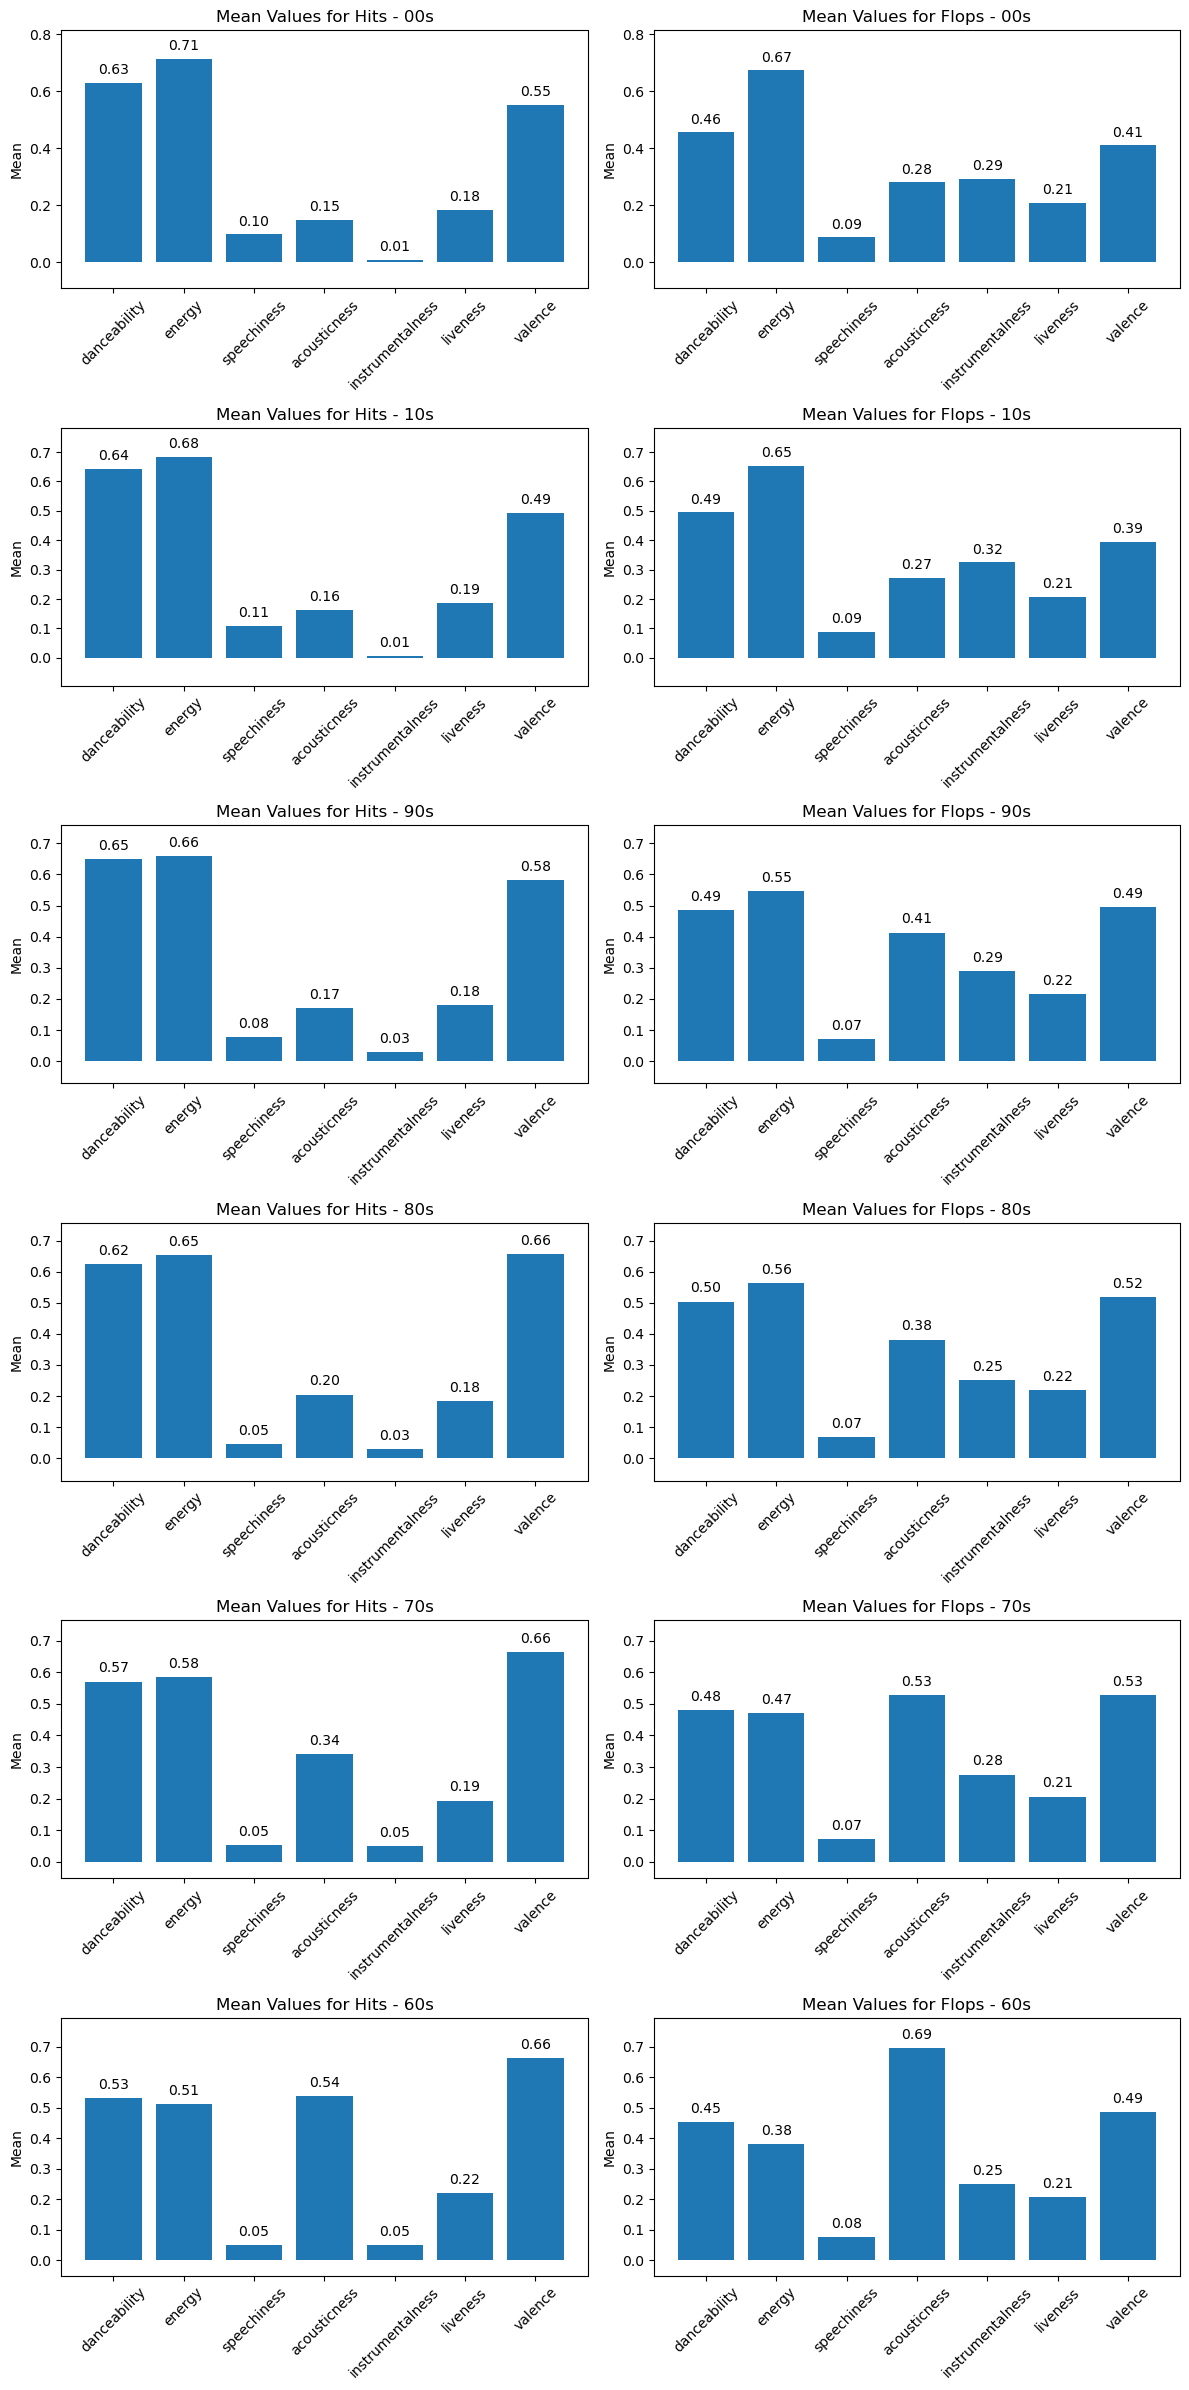

In [7]:
dataset_files = ['./data/dataset-of-00s.csv', './data/dataset-of-10s.csv', './data/dataset-of-90s.csv',
                 './data/dataset-of-80s.csv', './data/dataset-of-70s.csv', './data/dataset-of-60s.csv']

fig, axes = plt.subplots(nrows=len(dataset_files), ncols=2, figsize=(12, 4 * len(dataset_files)))
plt.subplots_adjust(hspace=0.5)

for i, file in enumerate(dataset_files):
    # Extract decade from filename
    decade = os.path.splitext(os.path.basename(file))[0].split('-')[-1]
    df = pd.read_csv(file)
    hits_df = df[df['target'] == 1]
    flops_df = df[df['target'] == 0]

    # Plot hits
    hits_means = hits_df[selected_columns].mean()
    axes[i, 0].bar(hits_means.index, hits_means)
    axes[i, 0].set_title(f'Mean Values for Hits - {decade}')
    axes[i, 0].set_ylabel('Mean')

    for j, value in enumerate(hits_means):
        axes[i, 0].text(j, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

    axes[i, 0].set_ylim(min(hits_means.min(), flops_df[selected_columns].mean().min()) - 0.1,
                        max(hits_means.max(), flops_df[selected_columns].mean().max()) + 0.1)
    axes[i, 0].tick_params(axis='x', rotation=45)

    # Plot flops
    flops_means = flops_df[selected_columns].mean()
    axes[i, 1].bar(flops_means.index, flops_means)
    axes[i, 1].set_title(f'Mean Values for Flops - {decade}')
    axes[i, 1].set_ylabel('Mean')

    for j, value in enumerate(flops_means):
        axes[i, 1].text(j, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

    axes[i, 1].set_ylim(min(hits_means.min(), flops_means.min()) - 0.1,
                        max(hits_means.max(), flops_means.max()) + 0.1)
    axes[i, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## PCA for Finding Relevant Attributes
PCA is used to find the relevant attributes that is later used for the train test split.

In [8]:
attributes = ['danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence']

df_attributes = df[attributes]

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(df_attributes)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(standardized_data)

# Get the loadings of PC1 and PC2
loadings = pca.components_[:2, :]

# Get the attribute names
attribute_names = df_attributes.columns

# Sort attributes based on loadings
pc1_sorted_attributes = [attribute_names[i] for i in (-loadings[0]).argsort()]
pc2_sorted_attributes = [attribute_names[i] for i in (-loadings[1]).argsort()]

# Create list of attributes with the most variation
selected_attributes = [pc1_sorted_attributes[0], pc2_sorted_attributes[0], pc1_sorted_attributes[1], pc2_sorted_attributes[1]]

# Print the first attribute of PC1 and PC2
print("Attribute 1 primarily represented by PC1:", pc1_sorted_attributes[0])
print("Attribute 1 primarily represented by PC2:", pc2_sorted_attributes[0])
print("Attribute 2 primarily represented by PC1:", pc1_sorted_attributes[1])
print("Attribute 2 primarily represented by PC2:", pc2_sorted_attributes[1])

Attribute 1 primarily represented by PC1: acousticness
Attribute 1 primarily represented by PC2: speechiness
Attribute 2 primarily represented by PC1: instrumentalness
Attribute 2 primarily represented by PC2: liveness


## Train Test Split
The train_test_split technique from the Scikit Learn Library is used to randomize the split on the concatenated dataset. The baseline accuracy is then calculated and printed to be used for comparison to the three models.

In [14]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=np.random.randint(0, 100))

X_train = df_train[selected_attributes]
y_train = df_train['target'].ravel()

X_test = df_test[selected_attributes]
y_test = df_test['target'].ravel()

cv_values = range(2, 11)

X_full = np.concatenate((X_train, X_test))
y_full = np.concatenate((y_train, y_test))

# Baseline for classification (assign every test data point to the majority class)
majority_class_baseline = np.ones_like(y_test) * np.bincount(y_train).argmax()

# Calculate accuracy for the classification baseline
classification_baseline_accuracy = accuracy_score(y_test, majority_class_baseline)
print(f"Classification Baseline Accuracy: {classification_baseline_accuracy:0.5f}")

Classification Baseline Accuracy: 0.49161


## Decision Tree

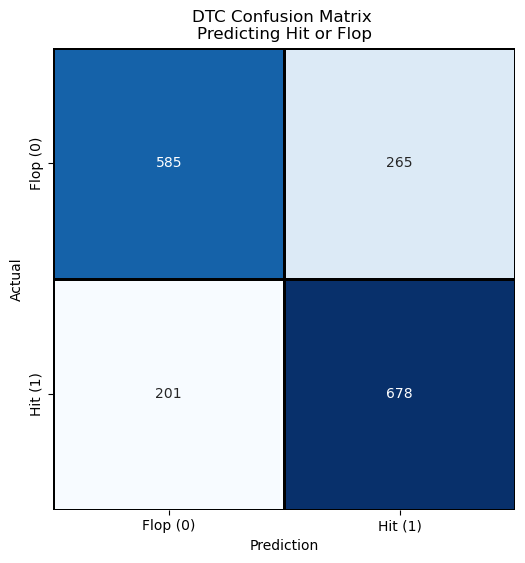

DTC Accuracy: 0.73048
DTC Cross-Validation Score: 0.71130


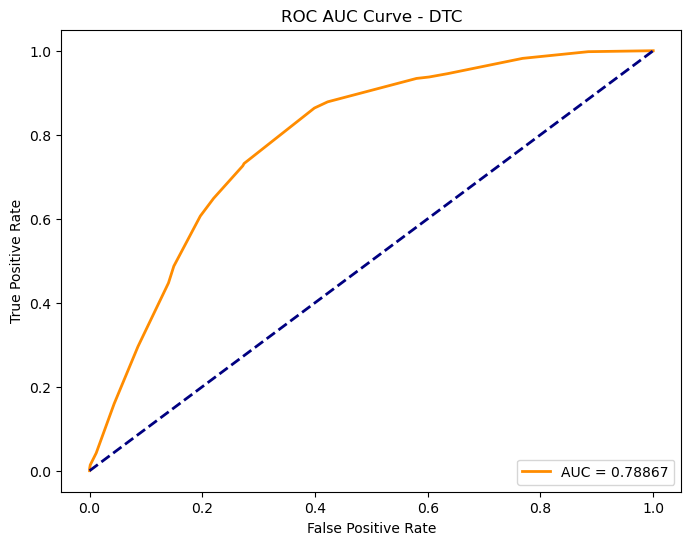

DTC time taken: 0.5794 seconds


In [15]:
dtc_start_time = time.time()

dtc = DecisionTreeClassifier(criterion='gini', min_samples_split=750)
dtc.fit(X_train, y_train)
dtc_y_pred = dtc.predict(X_test)

# Plot the confusion matrix
dtc_conf_matrix = confusion_matrix(y_test, dtc_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(dtc_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Flop (0)', 'Hit (1)'], yticklabels=['Flop (0)', 'Hit (1)'],
            linewidths=1, linecolor='black', square=True)
plt.title("DTC Confusion Matrix \nPredicting Hit or Flop")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

# Evaluate accuracy and cross-validation score
dtc_cv_score = cross_val_score(dtc, X_full, y_full, cv=5, scoring='accuracy').mean()
print(f"DTC Accuracy: {dtc.score(X_test, y_test):0.5f}")
print(f"DTC Cross-Validation Score: {dtc_cv_score:0.5f}")

# Compute ROC curve and AUC
dtc_y_probs = dtc.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, dtc_y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = {:0.5f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve - DTC')
plt.legend(loc='lower right')
plt.show()

dtc_end_time = time.time()
print(f"DTC time taken: {round(dtc_end_time - dtc_start_time, 4)} seconds")

## Random Forest

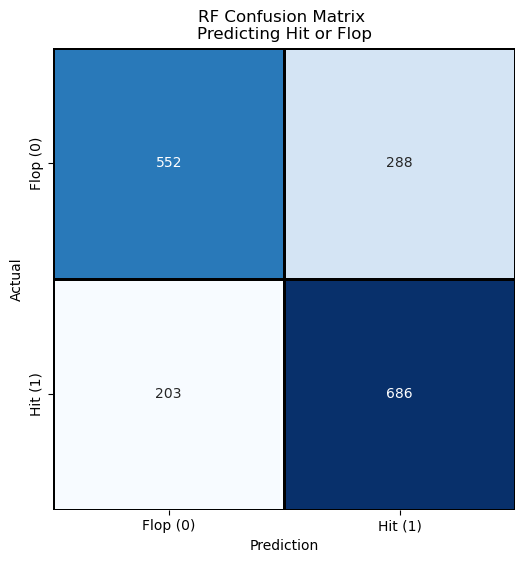

RF Accuracy: 0.71602
RF Cross-Validation Score: 0.72148


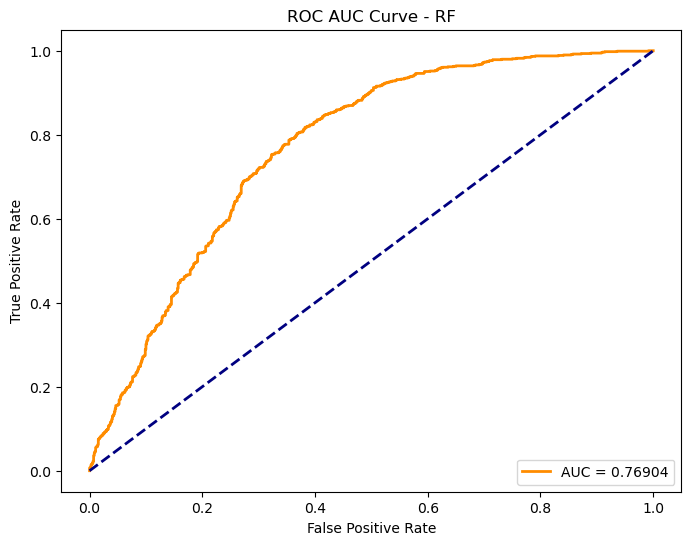

RF time taken: 9.7187 seconds


In [11]:
rf_start_time = time.time()

rf = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=350)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# Plot the confusion matrix
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Flop (0)', 'Hit (1)'], yticklabels=['Flop (0)', 'Hit (1)'],
            linewidths=1, linecolor='black', square=True)
plt.title("RF Confusion Matrix \nPredicting Hit or Flop")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

# Evaluate accuracy and cross-validation score
rf_cv_score = cross_val_score(rf, X_full, y_full, cv=5, scoring='accuracy').mean()
print(f"RF Accuracy: {rf.score(X_test, y_test):0.5f}")
print(f"RF Cross-Validation Score: {rf_cv_score:0.5f}")

# Compute ROC curve and AUC
rf_y_probs = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_y_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='AUC = {:0.5f}'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve - RF')
plt.legend(loc='lower right')
plt.show()

rf_end_time = time.time()
print(f"RF time taken: {round(rf_end_time - rf_start_time, 4)} seconds")

## Multi-Layer Perceptron

C:\Users\amand\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


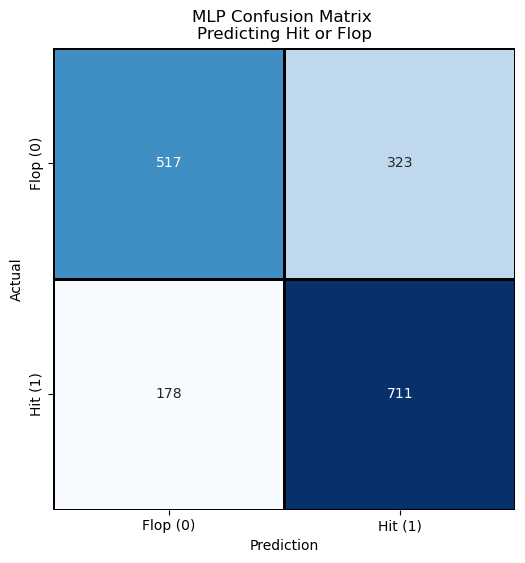

C:\Users\amand\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\amand\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Accuracy: 0.71024
MLP Cross-Validation Score: 0.71396


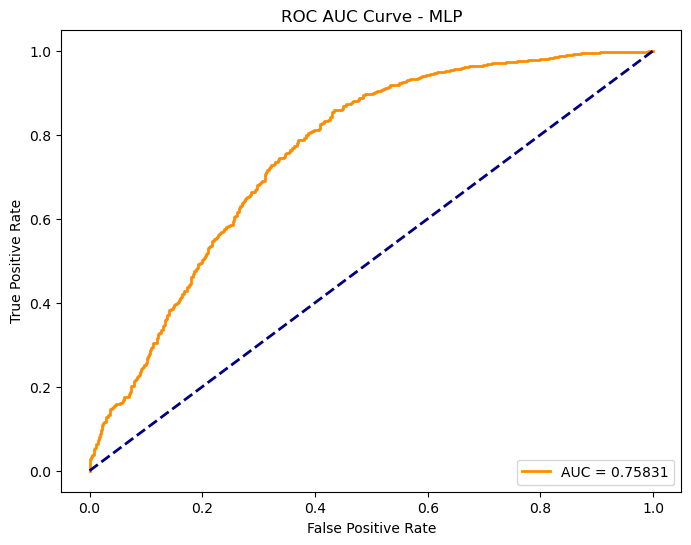

MLP time taken: 20.2094 seconds


In [12]:
mlp_start_time = time.time()

mlp = MLPClassifier()
mlp.fit(X_train, y_train)
mlp_y_pred = mlp.predict(X_test)

# Plot the confusion matrix
mlp_conf_matrix = confusion_matrix(y_test, mlp_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(mlp_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Flop (0)', 'Hit (1)'], yticklabels=['Flop (0)', 'Hit (1)'],
            linewidths=1, linecolor='black', square=True)
plt.title("MLP Confusion Matrix \nPredicting Hit or Flop")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

# Evaluate accuracy and cross-validation score
mlp_cv_score = cross_val_score(mlp, X_full, y_full, cv=5, scoring='accuracy').mean()
print(f"MLP Accuracy: {mlp.score(X_test, y_test):0.5f}")
print(f"MLP Cross-Validation Score: {mlp_cv_score:0.5f}")

# Compute ROC curve and AUC
mlp_y_probs = mlp.predict_proba(X_test)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_y_probs)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label='AUC = {:0.5f}'.format(roc_auc_mlp))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve - MLP')
plt.legend(loc='lower right')
plt.show()

mlp_end_time = time.time()
print(f"MLP time taken: {round(mlp_end_time - mlp_start_time, 4)} seconds")